In [32]:
import numpy as np
import gpflow as gp

import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf


D = 1  # number of input dimensions
M = 10  # number of inducing points
L = 4  # number of latent GPs
P = 10  # number of observations = output dimensions

noise = 0.3

X = np.tile(np.linspace(0,2,M*4)[:,None],(1,D))
Y = np.concatenate([p*np.sin(10*X)+np.sin(10*X*p) + noise*np.random.normal(size=X.shape) for p in range(1,P+1)],axis=1)

def _kern():
    return gp.kernels.Matern32(D)
    
with gp.defer_build():

    W = np.random.normal(size=(P,L))

    kern = mk.SeparateMixedMok([_kern() for _ in range(L)], W)

    feature_list = [gp.features.InducingPoints(X[np.random.choice(X.shape[0],size=M,replace=False),:]) for l in range(L)]
    feature = mf.MixedKernelSeparateMof(feature_list)

    q_mu = np.zeros((M, L))
    q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

    likelihood = gp.likelihoods.Gaussian()
    likelihood.variance = noise
    likelihood.variance.trainable = False

    model = gp.models.SVGP(X, Y, kern, likelihood, 
                feat = feature,
                minibatch_size=None,
                num_data = X.shape[0],
                whiten=False,
              q_mu = q_mu,
              q_sqrt = q_sqrt)
    model.compile()

opt = gp.train.AdamOptimizer(1e-2)
print(model.predict_density(X,Y).mean())
opt.minimize(model, maxiter=10000)
print(model.predict_density(X,Y).mean())

-3.3499339424284313
-1.1269586174583452


In [33]:
ystar,varstar = model.predict_f(X)

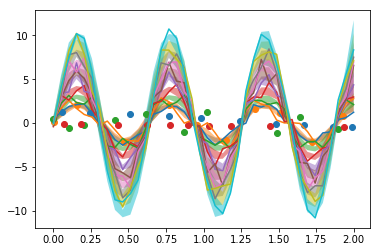

In [43]:
import pylab as plt
[plt.plot(X[:,0],Y[:,p]) for p in range(P)]
[plt.fill_between(X[:,0],ystar[:,p]-2*np.sqrt(varstar[:,p]),ystar[:,p]+2*np.sqrt(varstar[:,p]),alpha=0.5) for p in range(P)]
for feat, q in zip(model.feature.feat_list,model.q_mu.value.T):
    plt.scatter(feat.Z.value,q)
plt.show()

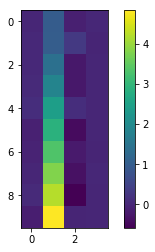

In [35]:
plt.imshow(model.kern.W.value)
plt.colorbar()
plt.show()

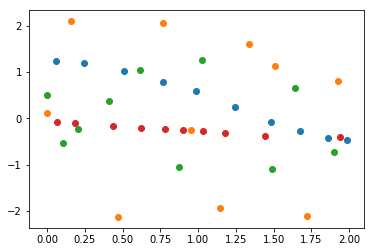